In [1]:
import datetime as dt
from math import sqrt
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
from sklearn.metrics import mean_squared_error
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller

[*********************100%***********************]  1 of 1 completed


Training set length: 200
Testing set length: 51
ADF Statistic: -0.9886541834735227
p-value: 0.7573799009999216
ADF Statistic (after differencing): -13.154205429551382
p-value (after differencing): 1.3476551320245158e-24


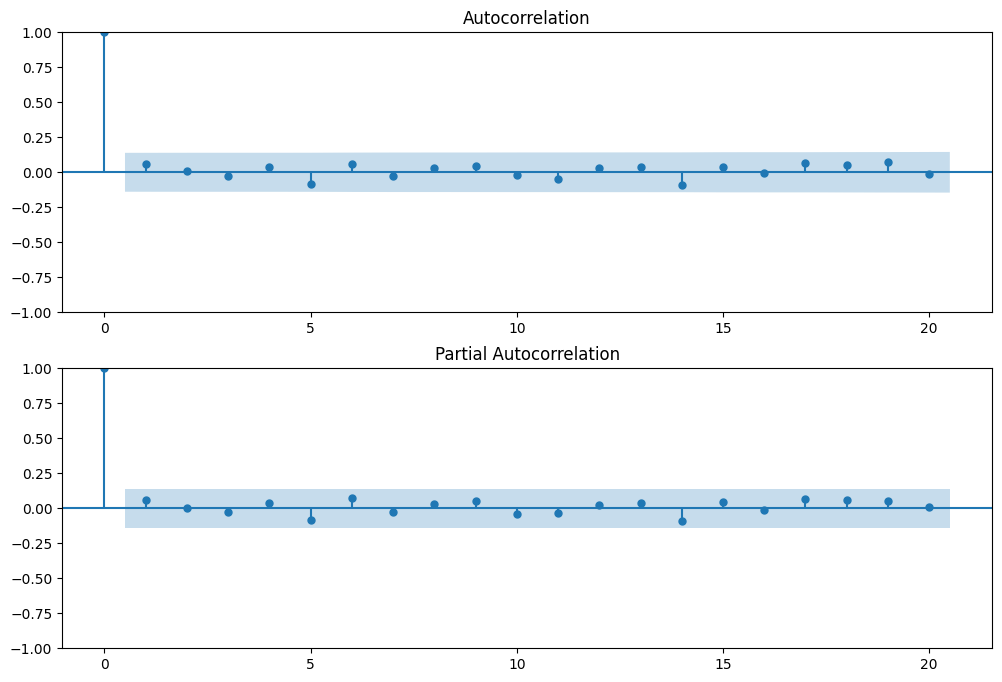

In [2]:
# Define the stock ID and date range
stock_id = "AAPL"
end = dt.date.today()
start = end - dt.timedelta(days=365)

# Download stock data
df_stat = yf.download(stock_id, start=start, end=end)
close_prices = df_stat['Close'].dropna()

# Split data into training (80%) and testing (20%) sets
train_size = int(len(close_prices) * 0.8)
train, test = close_prices[:train_size], close_prices[train_size:]

print(f"Training set length: {len(train)}")
print(f"Testing set length: {len(test)}")

# Perform ADF test to check stationarity
result = adfuller(train)
print('ADF Statistic:', result[0])
print('p-value:', result[1])

# If data is non-stationary, perform first-order differencing
if result[1] > 0.05:
    differenced_train = train.diff().dropna()
    result = adfuller(differenced_train)
    print('ADF Statistic (after differencing):', result[0])
    print('p-value (after differencing):', result[1])
else:
    differenced_train = train

# Plot ACF and PACF
plt.figure(figsize=(12, 8))
plt.subplot(211)
plot_acf(differenced_train, ax=plt.gca(), lags=20)
plt.subplot(212)
plot_pacf(differenced_train, ax=plt.gca(), lags=20)
plt.show()



In [3]:
# Determine the best ARIMA model parameters (p, d, q)
p_values = range(0, 6)
d_values = range(0, 3)
q_values = range(0, 6)

best_score, best_cfg = float("inf"), None
for p in p_values:
    for d in d_values:
        for q in q_values:
            try:
                model = ARIMA(train, order=(p, d, q))
                model_fit = model.fit()
                yhat = model_fit.forecast(steps=len(test))
                error = mean_squared_error(test, yhat)
                if error < best_score:
                    best_score, best_cfg = error, (p, d, q)
            except Exception as e:
                print(f"Error fitting ARIMA({p},{d},{q}): {e}")
                continue

print(f'Best parameters: {best_cfg}')


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/p

Best parameters: (3, 2, 0)


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/p

Next 7 days forecast: 200    211.414418
201    211.545782
202    212.607576
203    213.589237
204    213.583574
205    214.045353
206    214.681188
Name: predicted_mean, dtype: float64


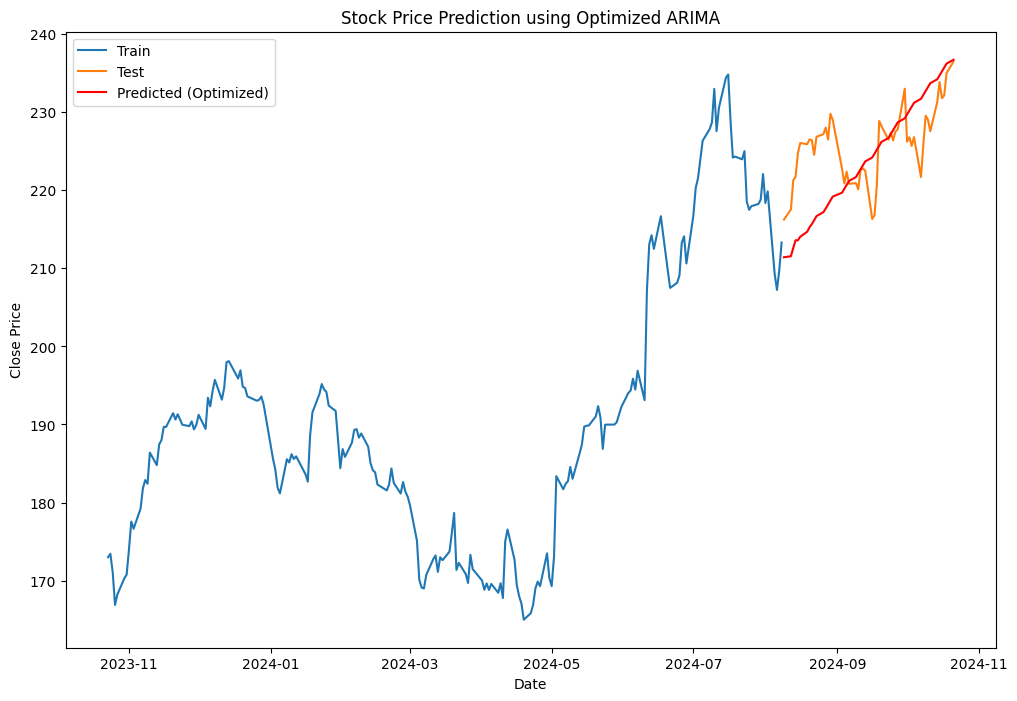

In [4]:
# Train ARIMA model with the best parameters
model = ARIMA(train, order=best_cfg)
model_fit = model.fit()

# Forecast the next 7 days
yhat = model_fit.forecast(steps=7)
print(f'Next 7 days forecast: {yhat}')

# Plot the forecast results
plt.figure(figsize=(12, 8))
plt.plot(train.index, train, label='Train')
plt.plot(test.index, test, label='Test')
plt.plot(test.index, model_fit.forecast(steps=len(test)), label='Predicted (Optimized)', color='red')
plt.title('Stock Price Prediction using Optimized ARIMA')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.show()

# Calculate RMSE
rmse_optimized = sqrt(mean_squared_error(test, model_fit.forecast(steps=len(test))))
print(f"RMSE: {rmse_optimized}")

RMSE: 6.281242222836712


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
<ipython-input-5-caeef60b1359>:11: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pand

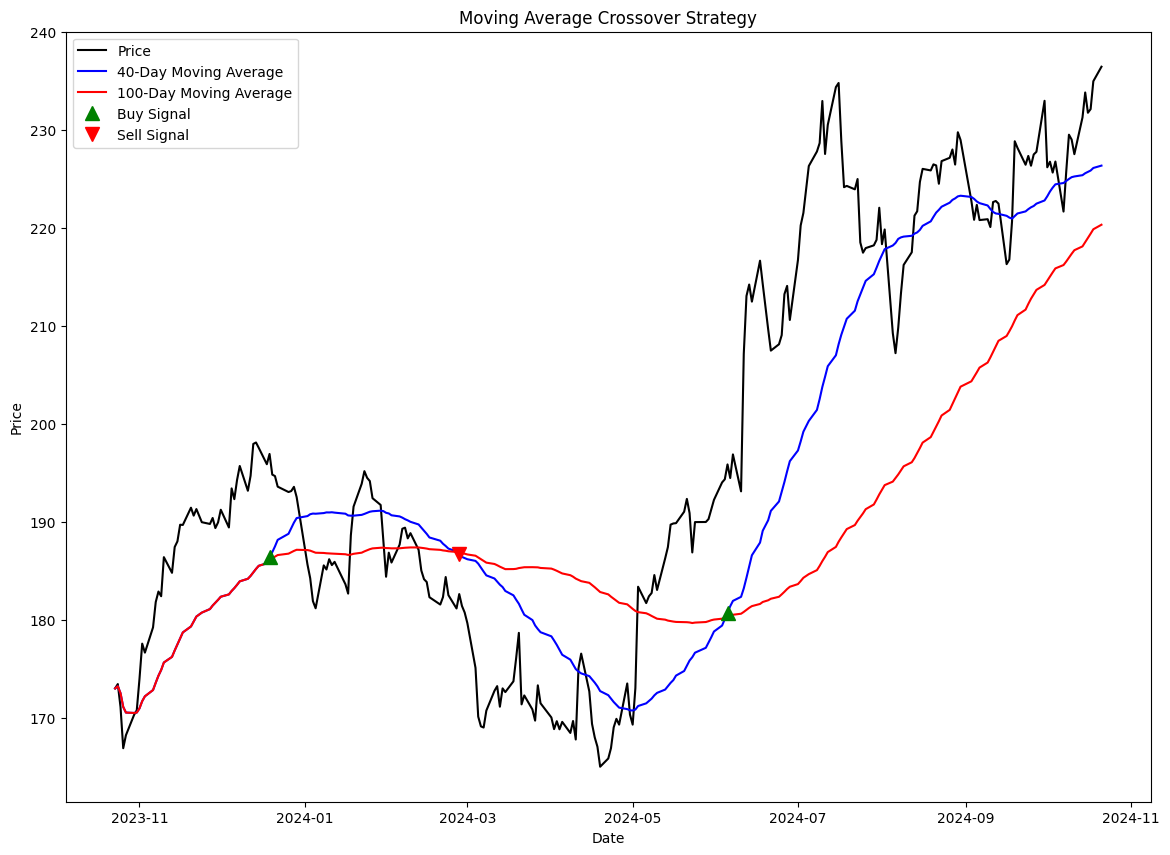

In [5]:
# Implement a simple moving average crossover trading strategy
short_window = 40
long_window = 100

signals = pd.DataFrame(index=close_prices.index)
signals['price'] = close_prices
signals['short_mavg'] = close_prices.rolling(window=short_window, min_periods=1, center=False).mean()
signals['long_mavg'] = close_prices.rolling(window=long_window, min_periods=1, center=False).mean()

signals['signal'] = 0.0
signals['signal'][short_window:] = np.where(signals['short_mavg'][short_window:] > signals['long_mavg'][short_window:], 1.0, 0.0)  # Buy signal
signals['positions'] = signals['signal'].diff()

# Plot the trading signals
plt.figure(figsize=(14, 10))
plt.plot(signals.index, signals['price'], label='Price', color='black')
plt.plot(signals.index, signals['short_mavg'], label='40-Day Moving Average', color='blue')
plt.plot(signals.index, signals['long_mavg'], label='100-Day Moving Average', color='red')
plt.plot(signals[signals['positions'] == 1.0].index,
         signals['short_mavg'][signals['positions'] == 1.0],
         '^', markersize=10, color='g', lw=0, label='Buy Signal')
plt.plot(signals[signals['positions'] == -1.0].index,
         signals['short_mavg'][signals['positions'] == -1.0],
         'v', markersize=10, color='r', lw=0, label='Sell Signal')
plt.title('Moving Average Crossover Strategy')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()


In [6]:
# Backtest the strategy
initial_balance = 10000.0
balance = initial_balance
position = 0

for i in range(1, len(signals)):
    if signals['positions'].iloc[i] == 1.0:  # Buy
        position = balance / signals['price'].iloc[i]
        balance = 0.0
    elif signals['positions'].iloc[i] == -1.0:  # Sell
        balance = position * signals['price'].iloc[i]
        position = 0.0

# Final value
if position > 0:
    balance = position * signals['price'].iloc[-1]

print(f"Final portfolio value: ${balance:.2f}")
print(f"Total return: {((balance - initial_balance) / initial_balance) * 100:.2f}%")

Final portfolio value: $11196.05
Total return: 11.96%
